<a href="https://colab.research.google.com/github/Yasmic/SpeedBump3AnchorBox/blob/master/yolo_train_Speed_bumpYasmi_inline_trainning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!git clone https://github.com/Yasmic/SpeedBump3AnchorBox
%cd SpeedBump3AnchorBox/
!pip install -r requirements.txt

Cloning into 'SpeedBump3AnchorBox'...
remote: Enumerating objects: 981, done.
remote: Total 981 (delta 0), reused 0 (delta 0), pack-reused 981
Receiving objects: 100% (981/981), 144.22 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (473/473), done.
/content/SpeedBump3AnchorBox/SpeedBump3AnchorBox


In [16]:
%cd /content/SpeedBump3AnchorBox/

/content/SpeedBump3AnchorBox


In [18]:
!rm  bump.pkl

rm: cannot remove 'bump.pkl': No such file or directory


In [19]:
pwd

'/content/SpeedBump3AnchorBox'

In [0]:
%pycat config.json

In [21]:
%%writefile config.json


{
    "model" : {
        "min_input_size":       288,
        "max_input_size":       448,
        "anchors":              [195,7, 219,15, 276,40, 291,25, 351,11, 382,58, 386,17, 401,33, 409,96],
        "labels":               ["bump"]
    },

    "train": {
        "train_image_folder":   "dataset/hump/hump/data/",
        "train_annot_folder":   "dataset/hump/hump/dataAnot/",
        "cache_name":           "bump.pkl",

        "train_times":          8,
        "batch_size":           4,
        "learning_rate":        1e-4,
        "nb_epochs":            100,
        "warmup_epochs":        3,
        "ignore_thresh":        0.5,
        "gpus":                 "0",

        "grid_scales":          [1,1,1],
        "obj_scale":            5,
        "noobj_scale":          1,
        "xywh_scale":           1,
        "class_scale":          1,

        "tensorboard_dir":      "logs",
        "saved_weights_name":   "bump.h5",
        "debug":                true
    },

    "valid": {
        "valid_image_folder":   "",
        "valid_annot_folder":   "",
        "cache_name":           "",

        "valid_times":          1
    }
}

Overwriting config.json


In [0]:
!python gen_anchors.py -c config.json

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


file_id = '1ED7de6kr0u3TZTJkxN8YafWRgsme9WHP'
destination = 'backend.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model, dummy_loss
from generator import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
import keras
from keras.models import load_model
from keras.utils import plot_model

config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

def create_training_instances(
    train_annot_folder,
    train_image_folder,
    train_cache,
    valid_annot_folder,
    valid_image_folder,
    valid_cache,
    labels,
):
    # parse annotations of the training set
    train_ints, train_labels = parse_voc_annotation(train_annot_folder, train_image_folder, train_cache, labels)

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(valid_annot_folder):
        valid_ints, valid_labels = parse_voc_annotation(valid_annot_folder, valid_image_folder, valid_cache, labels)
    else:
        print("valid_annot_folder not exists. Spliting the trainining set.")

        train_valid_split = int(0.8*len(train_ints))
        np.random.seed(0)
        np.random.shuffle(train_ints)
        np.random.seed()

        valid_ints = train_ints[train_valid_split:]
        train_ints = train_ints[:train_valid_split]

    # compare the seen labels with the given labels in config.json
    if len(labels) > 0:
        overlap_labels = set(labels).intersection(set(train_labels.keys()))

        print('Seen labels: \t'  + str(train_labels) + '\n')
        print('Given labels: \t' + str(labels))

        # return None, None, None if some given label is not in the dataset
        if len(overlap_labels) < len(labels):
            print('Some labels have no annotations! Please revise the list of labels in the config.json.')
            return None, None, None
    else:
        print('No labels are provided. Train on all seen labels.')
        print(train_labels)
        labels = train_labels.keys()

    max_box_per_image = max([len(inst['object']) for inst in (train_ints + valid_ints)])

    return train_ints, valid_ints, sorted(labels), max_box_per_image

def create_callbacks(saved_weights_name, tensorboard_logs, model_to_save):
    makedirs(tensorboard_logs)
    
    early_stop = EarlyStopping(
        monitor     = 'loss', 
        min_delta   = 0.01, 
        patience    = 7, 
        mode        = 'min', 
        verbose     = 1
    )
    checkpoint = CustomModelCheckpoint(
        model_to_save   = model_to_save,
        filepath        = saved_weights_name,# + '{epoch:02d}.h5', 
        monitor         = 'loss', 
        verbose         = 1, 
        save_best_only  = True, 
        mode            = 'min', 
        period          = 1
    )
    reduce_on_plateau = ReduceLROnPlateau(
        monitor  = 'loss',
        factor   = 0.1,
        patience = 2,
        verbose  = 1,
        mode     = 'min',
        epsilon  = 0.01,
        cooldown = 0,
        min_lr   = 0
    )
    tensorboard = CustomTensorBoard(
        log_dir                = tensorboard_logs,
        write_graph            = True,
        write_images           = True,
    )    
    return [early_stop, checkpoint, reduce_on_plateau, tensorboard]

def create_model(
    nb_class, 
    anchors, 
    max_box_per_image, 
    max_grid, batch_size, 
    warmup_batches, 
    ignore_thresh, 
    multi_gpu, 
    saved_weights_name, 
    lr,
    grid_scales,
    obj_scale,
    noobj_scale,
    xywh_scale,
    class_scale  
):
    if multi_gpu > 1:
        with tf.device('/cpu:0'):
            template_model, infer_model = create_yolov3_model(
                nb_class            = nb_class, 
                anchors             = anchors, 
                max_box_per_image   = max_box_per_image, 
                max_grid            = max_grid, 
                batch_size          = batch_size//multi_gpu, 
                warmup_batches      = warmup_batches,
                ignore_thresh       = ignore_thresh,
                grid_scales         = grid_scales,
                obj_scale           = obj_scale,
                noobj_scale         = noobj_scale,
                xywh_scale          = xywh_scale,
                class_scale         = class_scale
            )
    else:
        template_model, infer_model = create_yolov3_model(
            nb_class            = nb_class, 
            anchors             = anchors, 
            max_box_per_image   = max_box_per_image, 
            max_grid            = max_grid, 
            batch_size          = batch_size, 
            warmup_batches      = warmup_batches,
            ignore_thresh       = ignore_thresh,
            grid_scales         = grid_scales,
            obj_scale           = obj_scale,
            noobj_scale         = noobj_scale,
            xywh_scale          = xywh_scale,
            class_scale         = class_scale
        )  

    # load the pretrained weight if exists, otherwise load the backend weight only
    if os.path.exists(saved_weights_name): 
        print("\nLoading pretrained weights.\n")
        template_model.load_weights(saved_weights_name)
    else:
        template_model.load_weights("backend.h5", by_name=True)       

    if multi_gpu > 1:
        train_model = multi_gpu_model(template_model, gpus=multi_gpu)
    else:
        train_model = template_model      

    optimizer = Adam(lr=lr, clipnorm=0.001)
    train_model.compile(loss=dummy_loss, optimizer=optimizer)             

    return train_model, infer_model


In [0]:
!python train.py -c config.json


In [25]:
config_path = "config.json"
with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

###############################
#   Parse the annotations 
###############################
train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
    config['train']['train_annot_folder'],
    config['train']['train_image_folder'],
    config['train']['cache_name'],
    config['valid']['valid_annot_folder'],
    config['valid']['valid_image_folder'],
    config['valid']['cache_name'],
    config['model']['labels']
)
print('\nTraining on: \t' + str(labels) + '\n')

###############################
#   Create the generators 
###############################    
train_generator = BatchGenerator(
    instances           = train_ints, 
    anchors             = config['model']['anchors'],   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = config['train']['batch_size'],
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],   
    shuffle             = True, 
    jitter              = 0.3, 
    norm                = normalize
)
valid_generator = BatchGenerator(
    instances           = valid_ints, 
    anchors             = config['model']['anchors'],   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = config['train']['batch_size'],
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],   
    shuffle             = True, 
    jitter              = 0.0, 
    norm                = normalize
)

if os.path.exists(config['train']['saved_weights_name']): 
    config['train']['warmup_epochs'] = 0
warmup_batches = config['train']['warmup_epochs'] * (config['train']['train_times']*len(train_generator))   

os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
multi_gpu = len(config['train']['gpus'].split(','))

train_model, infer_model = create_model(
    nb_class            = len(labels), 
    anchors             = config['model']['anchors'], 
    max_box_per_image   = max_box_per_image, 
    max_grid            = [config['model']['max_input_size'], config['model']['max_input_size']], 
    batch_size          = config['train']['batch_size'], 
    warmup_batches      = warmup_batches,
    ignore_thresh       = config['train']['ignore_thresh'],
    multi_gpu           = multi_gpu,
    saved_weights_name  = config['train']['saved_weights_name'],
    lr                  = config['train']['learning_rate'],
    grid_scales         = config['train']['grid_scales'],
    obj_scale           = config['train']['obj_scale'],
    noobj_scale         = config['train']['noobj_scale'],
    xywh_scale          = config['train']['xywh_scale'],
    class_scale         = config['train']['class_scale'],
)

valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'bump': 465}

Given labels: 	['bump']

Training on: 	['bump']



In [0]:
plot_model(
train_model,
to_file="model.png",
show_shapes=True,
show_layer_names=True)

In [0]:
callbacks = create_callbacks(config['train']['saved_weights_name'], config['train']['tensorboard_dir'], infer_model)

history = train_model.fit_generator(
    generator        = train_generator, 
    steps_per_epoch  = len(train_generator) * config['train']['train_times'], 
    epochs           = config['train']['nb_epochs'] + config['train']['warmup_epochs'], 
    verbose          = 2 if config['train']['debug'] else 1,
    validation_data =  valid_generator,
    validation_steps =  len(valid_generator) * config['train']['train_times'],  #np.floor(valid_generator / batch_size)
    callbacks        = callbacks, 
    workers          = 4,
    max_queue_size   = 8
)


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


resizing:  352 352
resizing:  352 352
Epoch 1/103
resizing:  448 448
resizing:  352 352
resizing:  288 288
resizing:  320 320
resizing:  448 448
resizing:  352 352
resizing:  384 384
resizing:  352 352
resizing:  448 448
resizing:  448 448
resizing:  384 384
resizing:  320 320
resizing:  288 288
resizing:  448 448
resizing:  416 416
resizing:  416 416
resizing:  352 352
resizing:  352 352
resizing:  448 448
resizing:  448 448
resizing:  416 416
resizing:  448 448
resizing:  416 416
resizing:  320 320
resizing:  320 320
resizing:  448 448
resizing:  320 320
resizing:  288 288
resizing:  416 416
resizing:  448 448
resizing:  288 288
resizing:  288 288
resizing:  288 288
resizing:  288 288
resizing:  448 448
resizing:  448 448
resizing:  352 352
resizing:  352 352
resizing:  288 288
resizing:  416 416
resizing:  320 320
resizing:  352 352
resizing:  448 448
resizing:  352 352
resizing:  448 448
resizing:  288 288
resizing:  320 320
resizing:  448 448
resizing:  352 352
resizing:  288 288


In [0]:
impot matplotlib.pyplot as plt
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.legend()

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


file_id = '18VrI5goPlwbjxNjISmtMmjVBkzmdJBUF'
destination = 'bump.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
!python predict.py -c config.json -i dataset/hump/hump_test/data/imgge15.jpg

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-18 16:21:07.847895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-18 16:21:07.883841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-18 16:21:07.884418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-05-18 16:21:07.884765: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-18 16:21:07.886027: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-05-18 16:21:07.887306: I tensorflo

In [0]:
!python predict.py -c config.json -i dataset/hump/hump/data/Image00008.jpg

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-18 16:23:38.291935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-18 16:23:38.331834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-18 16:23:38.332630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-05-18 16:23:38.333002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-18 16:23:38.334524: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-05-18 16:23:38.335815: I tensorflo

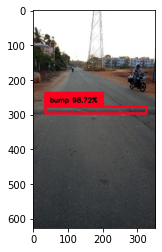

In [0]:
import matplotlib.pyplot as plt
my_img = plt.imread('output/imgge15.jpg')
plt.imshow(my_img)

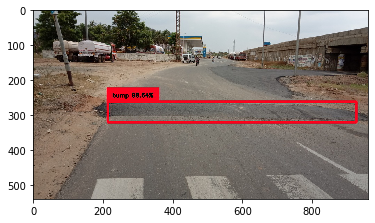

In [0]:
import matplotlib.pyplot as plt
my_img = plt.imread('output/2.jpg')
plt.imshow(my_img)

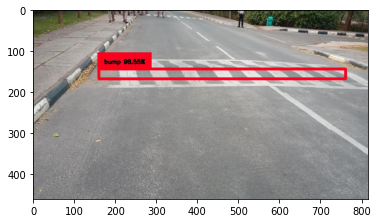

In [0]:
import matplotlib.pyplot as plt
my_img = plt.imread('output/Image00008.jpg')
plt.imshow(my_img)

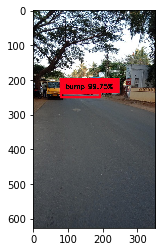

In [0]:
my_img = plt.imread('output/imgge62.jpg')
plt.imshow(my_img)

#Copy to drive

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cp -r  /content/SpeedBump3AnchorBox/ /content/drive/'My Drive'/SpeedBump3AnchorBox

In [0]:
ls /content/drive/'My Drive'/yoloSpeedBumpExperimental

backend.h5                generator.py  requirements.txt
bump.h5                   LICENSE       train.py
bump.pkl                  logs/         utils/
callbacks.py              model_1.png   voc.py
config.json               model.png     yolo.py
create_validation_set.sh  output/       yolo_train_Speed_bumpYasmi.ipynb
dataset/                  predict.py    zoo/
evaluate.py               __pycache__/
gen_anchors.py            README.md


In [0]:
drive.flush_and_unmount()